In [1]:
import numpy as np
import pandas as pd 
from sklearn import preprocessing as skp 
from sklearn import decomposition as skd
from sklearn.cluster import DBSCAN
import utils as ut

In [2]:
df = pd.read_csv('data/net_data.csv')
df.head()
X_Columns = ['Avg Byte Sent', 'No HTTP Requests', 'Number Unique URLs', 'Number TCP Session', 'Number of Peers']
Raw_X = df[X_Columns].to_numpy()
Raw_Y = df['Machine Number'].to_numpy()

In [3]:
def plot_map(X, Y=None):
    scaler = skp.MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    pca = skd.PCA(n_components=2)
    pca_X = pca.fit_transform(scaled_X)
    if Y is None: 
        Y = [1 for _x in scaled_X]
    pca_df = pd.DataFrame({'PCA1':pca_X[:,0], 'PCA2': pca_X[:,1], 'Y':Y})
    
    ut.plot_df(pca_df,'PCA1','PCA2','Y')

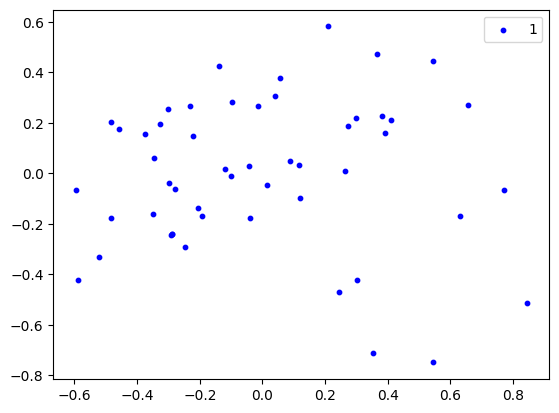

In [4]:
plot_map(Raw_X)

In [5]:
class AnomalyModel:
    
    def __init__(self):
        self.model = self.get_model()
        self.scaler = None
    
    
    def fit_predict(self, features, Y):
        self.fit(features)
        return self.predict(features, Y)
    
    def fit(self, features): 
        self.scaler = skp.MinMaxScaler()
        scaled_features = self.scaler.fit_transform(features)
        self.fit_raw(scaled_features) 
    
    def predict(self, features, Y):
        if self.scaler is None: 
            self.fit(features)
        scaled_features = self.scaler.fit_transform(features)
        return self.predict_raw(scaled_features,Y)
        
    
    #Subclasses should implement these functions 
    def get_model(self): 
        pass 
    
    def predict_raw(self, features, Y):
        pass

    def fit_raw(self, features):
        pass
        
    
    
class ClusteringPredictor(AnomalyModel):
    def get_model(self):
        return DBSCAN()
    
    def predict_raw(self, features, Y):
        labels = self.model.labels_.astype(int)
        return [Y[i] for i, x in enumerate(features) if labels[i] == -1]

    def fit_raw(self, features):
        self.model.fit(features)

In [6]:
def plot_anomaly(X, Y, anomalies):
    scaler = skp.MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    pca = skd.PCA(n_components=2)
    pca_X = pca.fit_transform(scaled_X)
    Label = ['Abnormal' if Y[i] in anomalies else 'Normal' for i,x in enumerate(pca_X)]

    pca_df = pd.DataFrame({'PCA1':pca_X[:,0], 'PCA2': pca_X[:,1], 'Y':Label})
    
    ut.plot_df(pca_df,'PCA1','PCA2','Y')

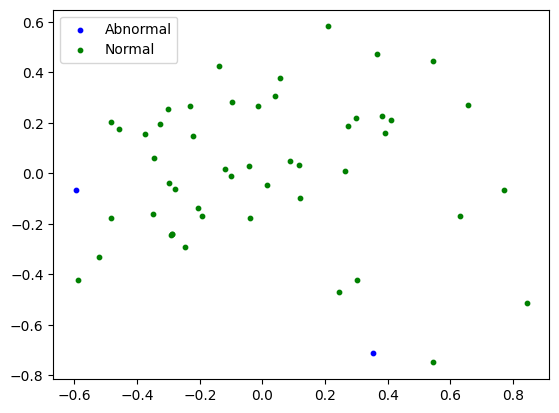

In [7]:
det = ClusteringPredictor()
pred = det.fit_predict(Raw_X, Raw_Y)
plot_anomaly(Raw_X, Raw_Y, pred)

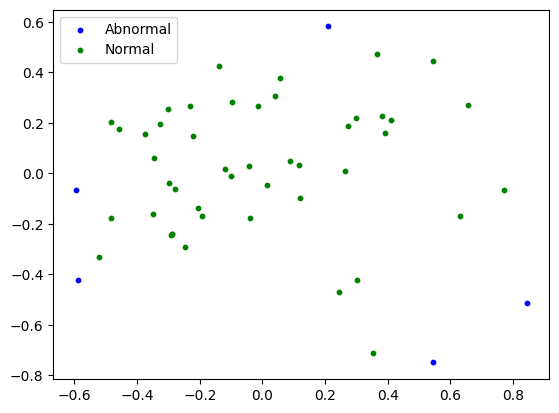

In [8]:
from sklearn import neural_network as skn 


class AutoEncoderModel(AnomalyModel):
    
    def __init__(self, input_dim:int):
        self.input_dim = input_dim
        super().__init__()
    
    def get_model(self):
        model = skn.MLPRegressor(hidden_layer_sizes=(self.input_dim, 4,2,2,4, self.input_dim), max_iter=500)
        return model 
    
    def fit_raw(self, features):
        self.model.fit(features, features)
    
    def predict_raw(self, features, Y):      
        raw_predictions = self.model.predict(features)
        errors = np.sqrt(np.mean(np.power(raw_predictions - features, 2), axis=1))
        this_len = errors.shape[0]
        quantile = np.quantile(errors, 0.9)
        choices = [Y[i] for i,x in enumerate(errors) if x > quantile] 
        return choices


det = AutoEncoderModel(len(X_Columns))
pred = det.fit_predict(Raw_X, Raw_Y)
plot_anomaly(Raw_X, Raw_Y, pred)